In [1]:
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt

from keras.preprocessing.image import ImageDataGenerator
from keras.applications.densenet import DenseNet121
from keras.layers import Dense, GlobalAveragePooling2D
from keras.models import Model
from keras import backend as k_backend

from keras.models import load_model

import util

Using TensorFlow backend.


In [2]:
# Read the data of train-small, valid-small, test ~ (files)
# Using the Pandas library to open the files

dataframe_of_train = pd.read_csv("nih/small-train-set.csv")
dataframe_of_valid = pd.read_csv("nih/small-valid-set.csv")
dataframe_of_test = pd.read_csv("nih/test.csv")

dataframe_of_train.head()

,Image,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,Nodule,PatientId,Pleural_Thickening,Pneumonia,Pneumothorax
0,00008270_015.png,0,0,0,0,0,0,0,0,0,0,0,8270,0,0,0
1,00029855_001.png,1,0,0,0,1,0,0,0,1,0,0,29855,0,0,0
2,00001297_000.png,0,0,0,0,0,0,0,0,0,0,0,1297,1,0,0
3,00012359_002.png,0,0,0,0,0,0,0,0,0,0,0,12359,0,0,0
4,00017951_001.png,0,0,0,0,0,0,0,0,1,0,0,17951,0,0,0


In [3]:
labels = ['Cardiomegaly', 
          'Emphysema', 
          'Effusion', 
          'Hernia', 
          'Infiltration', 
          'Mass', 
          'Nodule', 
          'Atelectasis',
          'Pneumothorax',
          'Pleural_Thickening', 
          'Pneumonia', 
          'Fibrosis', 
          'Edema', 
          'Consolidation']

In [4]:
def check_data_leakage(dataframe1, dataframe2, patient_id_column):
    
    dataframe1_patients_unique = set(dataframe1[patient_id_column].values)
    dataframe2_patients_unique = set(dataframe2[patient_id_column].values)
    
    patients_in_both_dataframes = dataframe1_patients_unique.intersection(dataframe2_patients_unique)

    # leakage contains true if there is patient overlap, otherwise false.
    leakage = len(patients_in_both_dataframes) > 0 # boolean (true if there is at least 1 patient in both groups)
    
    
    return leakage

In [5]:
# Testing Case 1

print("Test Case 1: \n")
dataframe1 = pd.DataFrame({'patient_id': [0, 1, 2]})
dataframe2 = pd.DataFrame({'patient_id': [2, 3, 4]})

print("Dataframe 1")
print(dataframe1)
print("\n")
print("Dataframe 2")
print(dataframe2)

print("\n")
print(f"Leakage Output: {check_data_leakage(dataframe1, dataframe2, 'patient_id')}")


Test Case 1: 

Dataframe 1
   patient_id
0           0
1           1
2           2


Dataframe 2
   patient_id
0           2
1           3
2           4


Leakage Output: True


In [6]:
# Testing Case 2

print("Test Case 2: \n")
dataframe1 = pd.DataFrame({'patient_id': [0, 1, 2]})
dataframe2 = pd.DataFrame({'patient_id': [3, 4, 5]})

print("Dataframe 1:")
print(dataframe1)
print("\n")
print("Dataframe 2:")
print(dataframe2)
print("\n")

print(f"Leakage Output: {check_data_leakage(dataframe1, dataframe2, 'patient_id')}")

Test Case 2: 

Dataframe 1:
   patient_id
0           0
1           1
2           2


Dataframe 2:
   patient_id
0           3
1           4
2           5


Leakage Output: False


In [7]:
print("Data leakage between train and test datasets: {}".format(check_data_leakage
                                                                (dataframe_of_train, dataframe_of_test, 'PatientId')))


print("Data leakage between valid and test datasets: {}".format(check_data_leakage
                                                                (dataframe_of_valid, dataframe_of_test, 'PatientId')))

Data leakage between train and test datasets: False
Data leakage between valid and test datasets: False


In [8]:
def get_train_generator(dataframe, 
                        image_files_dir, 
                        x_name_column_dataframe, 
                        y_labels_images_column_list, 
                        shuffle=True, 
                        images_batch_size=8, 
                        random_seed=1, 
                        images_width = 320, 
                        images_height = 320):
    
    print("Getting train generator...") 
    # normalize images
    image_generator = ImageDataGenerator(samplewise_center = True, samplewise_std_normalization = True)
    
    # flow from directory with specified batch size
    # and target image size
    generator = image_generator.flow_from_dataframe(dataframe = dataframe, 
                                                    directory = image_files_dir, 
                                                    x_col = x_name_column_dataframe, 
                                                    y_col = y_labels_images_column_list, 
                                                    class_mode = "raw", 
                                                    batch_size = images_batch_size, 
                                                    shuffle = shuffle, 
                                                    seed = random_seed, 
                                                    target_size = (images_width,images_height))
    
    return generator

In [9]:
def get_valid_and_test_generator(dataframe_of_valid, 
                                 dataframe_of_test, 
                                 dataframe_of_train, 
                                 image_files_dir, 
                                 x_name_column_dataframe, 
                                 y_labels_images_column_list, 
                                 sample_size = 100, 
                                 images_batch_size = 8, 
                                 random_seed = 1, 
                                 images_width = 320, 
                                 images_height = 320):
    
    print("Getting train and valid generators...")
    # get generator to sample dataset
    raw_train_generator = ImageDataGenerator().flow_from_dataframe(
        dataframe = dataframe_of_train, 
        directory = IMAGE_FILES_DIR, 
        x_col = "Image", 
        y_col = labels, 
        class_mode = "raw", 
        batch_size = sample_size, 
        shuffle = True, 
        target_size = (images_width, images_height))
    
    # get data sample
    batch = raw_train_generator.next()
    data_sample = batch[0]

    # use sample to fit mean and std for test set generator
    image_generator = ImageDataGenerator(featurewise_center=True, featurewise_std_normalization= True)
    
    # fit generator to sample from training data
    image_generator.fit(data_sample)

    # get test generator
    valid_generator = image_generator.flow_from_dataframe(
        dataframe = dataframe_of_valid, 
        directory = image_files_dir, 
        x_col = x_name_column_dataframe, 
        y_col = y_labels_images_column_list,
        class_mode = "raw", 
        batch_size = images_batch_size, 
        shuffle = False,
        seed = random_seed, 
        target_size = (images_width, images_height))

    test_generator = image_generator.flow_from_dataframe(
        dataframe = dataframe_of_test, 
        directory = image_files_dir, 
        x_col = x_name_column_dataframe, 
        y_col = y_labels_images_column_list,
        class_mode = "raw", 
        batch_size = images_batch_size, 
        shuffle = False, 
        seed = random_seed,
        target_size = (images_width,images_height))
    
    return valid_generator, test_generator

In [10]:
IMAGE_FILES_DIR = "nih/small-images-set/"

In [11]:
train_generator = get_train_generator(dataframe_of_train, IMAGE_FILES_DIR, "Image", labels)

Getting train generator...
Found 1000 validated image filenames.


In [12]:
valid_generator, test_generator= get_valid_and_test_generator(dataframe_of_valid, 
                                                              dataframe_of_test, 
                                                              dataframe_of_train, 
                                                              IMAGE_FILES_DIR, 
                                                              "Image", 
                                                              labels)

Getting train and valid generators...
Found 1000 validated image filenames.
Found 200 validated image filenames.
Found 420 validated image filenames.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


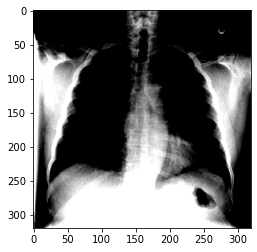

In [13]:
# Peek into what's the generator gives model during training and validation
x, y = train_generator.__getitem__(0)
plt.imshow(x[0]);

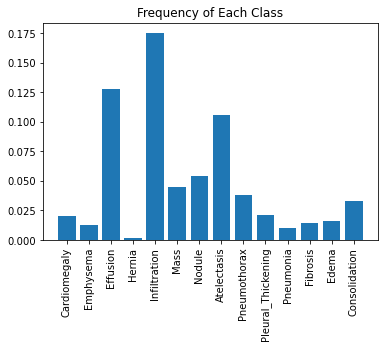

In [14]:
# Plot the frequency of each label
plt.xticks(rotation = 90)
plt.bar(x = labels, height=np.mean(train_generator.labels, axis = 0))
plt.title("Frequency of Each Class")
plt.show()

In [15]:
def compute_class_frequencies(labels):
    
    # total number of patients (rows)
    N = labels.shape[0]
    
    positive_frequencies = np.sum(labels, axis = 0) / N
    negative_frequencies = 1 - positive_frequencies

    return positive_frequencies, negative_frequencies

In [16]:
# Testing frequencies
labels_matrix = np.array(
    [[1, 0, 0],
     [0, 1, 1],
     [1, 0, 1],
     [1, 1, 1],
     [1, 0, 1]])

print("labels: \n", labels_matrix)
print("\n")

test_positive_frequencies, test_negative_frequencies = compute_class_frequencies(labels_matrix)

print(f"Positive Frequencies: {test_positive_frequencies}")
print(f"Negative Frequencies: {test_negative_frequencies}")

labels: 
 [[1 0 0]
 [0 1 1]
 [1 0 1]
 [1 1 1]
 [1 0 1]]


Positive Frequencies: [0.8 0.4 0.8]
Negative Frequencies: [0.2 0.6 0.2]


In [17]:
frequency_of_positive, frequency_of_negative = compute_class_frequencies(train_generator.labels)
frequency_of_positive

array([0.02 , 0.013, 0.128, 0.002, 0.175, 0.045, 0.054, 0.106, 0.038,
       0.021, 0.01 , 0.014, 0.016, 0.033])

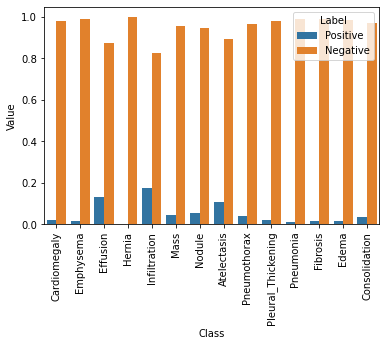

In [18]:
# Visualise the two contribution ratios for each of the pathologies
data = pd.DataFrame({"Class": labels, "Label": "Positive", "Value": frequency_of_positive})
data = data.append([{"Class": labels[l], "Label": "Negative", "Value": v} 
                    for l, v in enumerate(frequency_of_negative)], ignore_index=True)

plt.xticks(rotation = 90)
freq = sb.barplot(x = "Class", y = "Value", hue = "Label" ,data = data)

In [19]:
# Balancing the contribution of positive and negative labels
positive_weights = frequency_of_negative
negative_weights = frequency_of_positive
positive_contribution = frequency_of_positive * positive_weights 
negative_contribution = frequency_of_negative * negative_weights

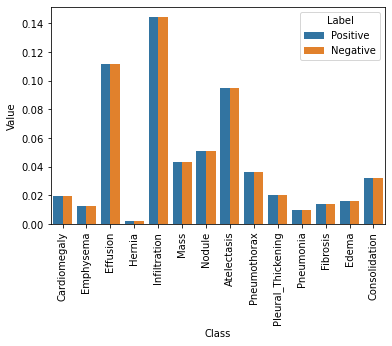

In [20]:
# Verify the positive and negative contribution
data = pd.DataFrame({"Class": labels, "Label": "Positive", "Value": positive_contribution})
data = data.append([{"Class": labels[l], "Label": "Negative", "Value": v} 
                    for l, v in enumerate(negative_contribution)], ignore_index = True)

plt.xticks(rotation = 90)
sb.barplot(x = "Class", y = "Value", hue = "Label" ,data = data);

In [21]:
def get_weighted_loss(positive_weights, negative_weights, epsilon = 1e-7):
    
    def weighted_loss(y_true_labels, y_predicted_labels):
        
        # initialize loss to 0
        loss = 0.0

        for i in range(len(positive_weights)):
            # for each class, add average weighted loss for that class 
            loss = loss + ((-1 * k_backend.mean(positive_weights[i] * y_true_labels[:, i] * 
                                                k_backend.log(y_predicted_labels[:, i] + epsilon))) + 
                           (-1 * k_backend.mean(negative_weights[i] * (1 - y_true_labels[:, i]) * 
                                                k_backend.log(1 - y_predicted_labels[:, i] + epsilon))))
        return loss
    
    return weighted_loss

In [22]:
# Test
sess = k_backend.get_session()
with sess.as_default() as sess:
    print("Test example:\n")
    y_true_labels = k_backend.constant(np.array(
        [[1, 1, 1],
         [1, 1, 0],
         [0, 1, 0],
         [1, 0, 1]]))
    
    print("y_true_labels:")
    print(y_true_labels.eval())
    print("\n")

    weighted_positive = np.array([0.25, 0.25, 0.5])
    weighted_negative = np.array([0.75, 0.75, 0.5])
    print("weighted_positive:", weighted_positive)
    print("weighted_negative:", weighted_negative)

    y_predicted_labels1 = k_backend.constant(0.7 * np.ones(y_true_labels.shape))
    print("\ny_predicted_labels1:")
    print(y_predicted_labels1.eval())

    y_predicted_labels2 = k_backend.constant(0.3 * np.ones(y_true_labels.shape))
    print("\ny_predicted_labels2:")
    print(y_predicted_labels2.eval())

    # test with a large epsilon in order to catch errors
    Loss = get_weighted_loss(weighted_positive, weighted_negative, epsilon = 1)

    print("\nIf weighted them correctly, expect the two losses to be the same.")
    Loss1 = Loss(y_true_labels, y_predicted_labels1).eval()
    Loss2 = Loss(y_true_labels, y_predicted_labels2).eval()
    print(f"\nLoss(y_predicted_labels1) = {Loss1:.4f}")
    print(f"\nLoss(y_predicted_labels2) = {Loss2:.4f}")
    print(f"\nDifference is Loss1 - Loss2 = {Loss1 - Loss2:.4f}")

Test example:

y_true_labels:
[[1. 1. 1.]
 [1. 1. 0.]
 [0. 1. 0.]
 [1. 0. 1.]]


weighted_positive: [0.25 0.25 0.5 ]
weighted_negative: [0.75 0.75 0.5 ]

y_predicted_labels1:
[[0.7 0.7 0.7]
 [0.7 0.7 0.7]
 [0.7 0.7 0.7]
 [0.7 0.7 0.7]]

y_predicted_labels2:
[[0.3 0.3 0.3]
 [0.3 0.3 0.3]
 [0.3 0.3 0.3]
 [0.3 0.3 0.3]]

If weighted them correctly, expect the two losses to be the same.

Loss(y_predicted_labels1) = -0.4956

Loss(y_predicted_labels2) = -0.4956

Difference is Loss1 - Loss2 = 0.0000


In [23]:
# Use a pre-trained DenseNet121 model
# Set loss function for the model

# create the base pre-trained model
base_model = DenseNet121(weights = './nih/densenet.hdf5', include_top = False)

x = base_model.output

# add a global spatial average pooling layer
x = GlobalAveragePooling2D()(x)

# and a logistic layer
predictions = Dense(len(labels), activation = "sigmoid")(x)

model = Model(inputs = base_model.input, outputs = predictions)
model.compile(optimizer = 'adam', loss = get_weighted_loss(positive_weights, negative_weights))

In [24]:
# Load pre-trained weights into the model
model.load_weights("./nih/pretrained_model.h5")

In [25]:
prediction_test_set = model.predict_generator(test_generator, steps = len(test_generator))

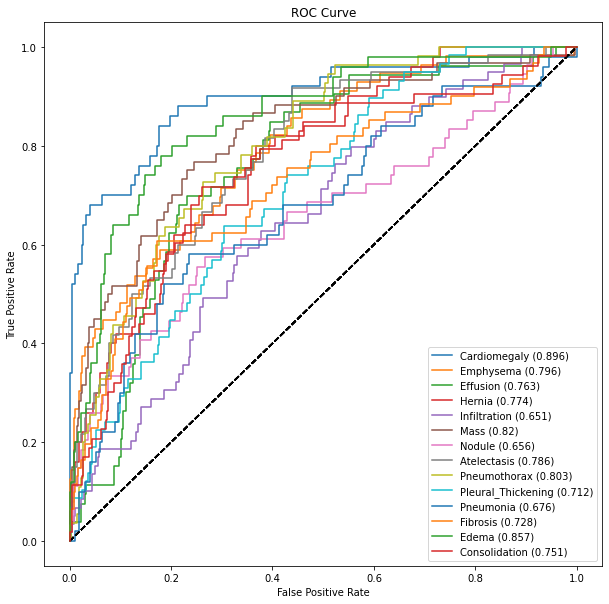

In [26]:
# Computing AUC(Area Under the Curve) from the ROC(Receiver Operating Characteristics) curve
auc_roc = util.get_roc_curve(labels, prediction_test_set, test_generator)

In [27]:
# Load the small training set 
# Setup to look at the 4 classes with the highest performing AUC measures
dataframe = pd.read_csv("nih/small-train-set.csv")
IMAGE_FILES_DIR = "nih/small-images-set/"

# show the labels with top 4 AUC
labels_to_show = np.take(labels, np.argsort(auc_roc)[::-1])[:4]

Loading original image
Generating Grad-CAM for class Cardiomegaly
Generating Grad-CAM for class Mass
Generating Grad-CAM for class Pneumothorax
Generating Grad-CAM for class Edema


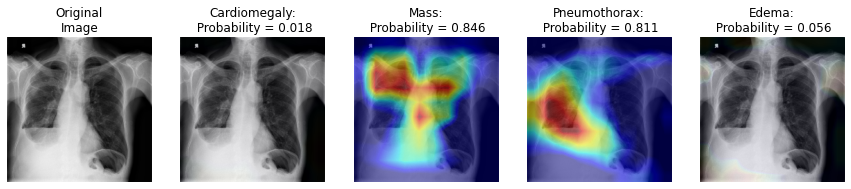

In [28]:
# Testing a few specific chest X-Ray images
img = '00000315_004.png'
util.compute_grad_cam(model, img, IMAGE_FILES_DIR, dataframe, labels, labels_to_show)

Loading original image
Generating Grad-CAM for class Cardiomegaly
Generating Grad-CAM for class Mass
Generating Grad-CAM for class Pneumothorax
Generating Grad-CAM for class Edema


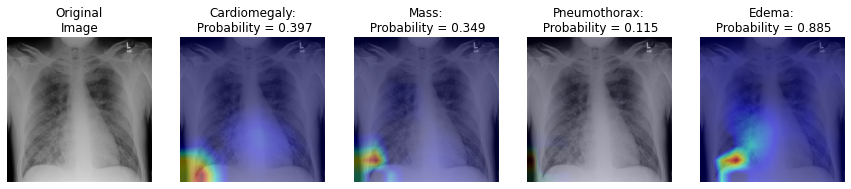

In [29]:
img = '00012777_005.png'
util.compute_grad_cam(model, img, IMAGE_FILES_DIR, dataframe, labels, labels_to_show)

Loading original image
Generating Grad-CAM for class Cardiomegaly
Generating Grad-CAM for class Mass
Generating Grad-CAM for class Pneumothorax
Generating Grad-CAM for class Edema


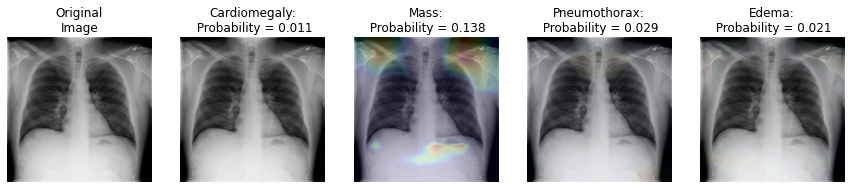

In [30]:
img = '00018383_000.png'
util.compute_grad_cam(model, img, IMAGE_FILES_DIR, dataframe, labels, labels_to_show)

In [31]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, None, None, 6 9408        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, None, None, 6 256         conv1/conv[0][0]                 
____________________________________________________________________________________________

In [32]:
from keras.models import model_from_json

In [33]:
# serialize model to JSON
model_json = model.to_json()
with open("trained_model.json", "w") as json_file:
    json_file.write(model_json)
    
# serialize weights to HDF5
model.save_weights("trained_model.h5")
print("Saved Model...")

Saved Model...


In [34]:
# load json and create model
json_file = open('trained_model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

# load weights into new model
loaded_model.load_weights("trained_model.h5")
print("Loaded Model...")

Loaded Model...


In [35]:
loaded_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, None, None, 6 9408        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, None, None, 6 256         conv1/conv[0][0]                 
____________________________________________________________________________________________